In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
 
# import VGG 19 model and keras Model API
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

In [25]:
from numpy import inf
%matplotlib inline


In [54]:
# Defining the content image and style image
content_path = tf.keras.utils.get_file('content.png',
                                       'https://www.artnews.com/wp-content/uploads/2022/01/unnamed-2.png?w=631')
style_path = tf.keras.utils.get_file('style2.jpg',
                                     'https://static01.nyt.com/images/2021/03/12/arts/11nft-auction-cryptopunks-print/11nft-auction-cryptopunks-print-mobileMasterAt3x.jpg')

49152/38366 [======================================] - 0s 0us/step


In [46]:
content_path

'/root/.keras/datasets/content.png'

## Now, we initialize the VGG model with ImageNet weights, we will also remove the top layers and make it non-trainable.

In [7]:
model = VGG19(
    include_top=False, #remove the top layers
    weights='imagenet'
)
# set training to False
model.trainable = False
 
model.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

 Now, we load and process the image using Keras preprocess input in VGG 19. The expand_dims function adds a dimension to represent a number of images in the input. This preprocess_input function (used in VGG 19 ) converts the input RGB to BGR images and centre these values around 0 according to ImageNet data (no scaling).


In [8]:

# code to load and process image
def load_and_process_image(image_path):
    img = load_img(image_path)
    # convert image to array
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

Now, we define the deprocess function that takes the input image and perform the inverse of preprocess_input function that we imported above. To display the unprocessed image, we also define a display function.

In [9]:

# code
def deprocess(img):
    # perform the inverse of the pre processing step
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # convert RGB to BGR
    img = img[:, :, ::-1]
 
    img = np.clip(img, 0, 255).astype('uint8')
    return img
 
 
def display_image(image):
    # remove one dimension if image has 4 dimension
    if len(image.shape) == 4:
        img = np.squeeze(image, axis=0)
 
    img = deprocess(img)
 
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return

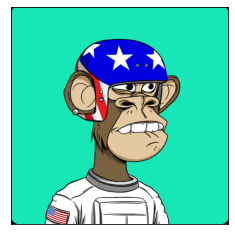

In [47]:
# load content image
content_img = load_and_process_image(content_path)
display_image(content_img)


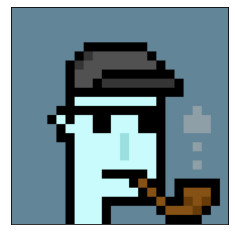

In [55]:
 
# load style image
style_img = load_and_process_image(style_path)
display_image(style_img)

Now, we define the content and style model using Keras.Model API. The content model takes the image as input and output the feature map from “block5_conv1” from the above VGG model.

In [13]:

# define content model
content_layer = 'block5_conv2'
content_model = Model(
    inputs=model.input,
    outputs=model.get_layer(content_layer).output
)
content_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Now, we define the content and style model using Keras.Model API. The style model takes an image as input and output the feature map from “block1_conv1, block3_conv1, and block5_conv2″ from the above VGG model.

In [14]:

# define style model
style_layers = [
    'block1_conv1',
    'block3_conv1',
    'block5_conv1'
]
style_models = [Model(inputs=model.input,
                      outputs=model.get_layer(layer).output) for layer in style_layers]

Now, we define the content loss function, it will take the feature map of generated and real images and calculate the mean square difference between them.


In [35]:
# Content loss
def content_loss(content, generated):
    a_C = content_model(content)
    a_G = content_model(generated)
    loss = tf.reduce_mean(tf.square(a_C - a_G))
    return loss

Now, we define the gram matrix and style loss function. This function also takes the real and generated images as the input of the model and calculates gram matrices of them before calculate the style loss weighted to different layers.

In [32]:

# gram matrix
def gram_matrix(A):
    channels = int(A.shape[-1])
    a = tf.reshape(A, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)
 
 
weight_of_layer = 1. / len(style_models)
 
 
# style loss
def style_cost(style, generated):
    J_style = 0
 
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        current_cost = tf.reduce_mean(tf.square(GS - GG))
        J_style += current_cost * weight_of_layer
 
    return J_style

Now, we define our training function, we will train our model to **100** iterations. This model takes input images, the number of iterations as its argument.

In [56]:
# training function
generated_images = []
 
 
def training_loop(content_path, style_path, iterations=100, a=10, b=1000):
    # load content and style images from their respective path
    content = load_and_process_image(content_path)
    style = load_and_process_image(style_path)
    generated = tf.Variable(content, dtype=tf.float32)
 
    opt = tf.keras.optimizers.Adam(learning_rate=7)
 
    best_cost = inf
    best_image = None
    for i in range(iterations):
        %%time
        with tf.GradientTape() as tape:
            J_content = content_loss(content, generated)
            J_style = style_cost(style, generated)
            J_total = a * J_content + b * J_style
 
        grads = tape.gradient(J_total, generated)
        opt.apply_gradients([(grads, generated)])
 
        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()
 
        print("Iteration :{}".format(i))
        print('Total Loss {:e}.'.format(J_total))
        generated_images.append(generated.numpy())
 
    return best_image

In [57]:
final_img = training_loop(content_path, style_path)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
Iteration :0
Total Loss 7.659404e+11.
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
Iteration :1
Total Loss 4.836683e+11.
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
Iteration :2
Total Loss 2.878470e+11.
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
Iteration :3
Total Loss 2.191882e+11.
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
Iteration :4
Total Loss 1.888771e+11.
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
Iteration :5
Total Loss 1.661481e+11.
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
Iteration :6
Total Loss 1.477408e+11.
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs
Iteration :7
Total Loss 1.330021e+11.
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
Iteration :8
Total Loss 1.229058e+11.
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
Iteration :9
Total

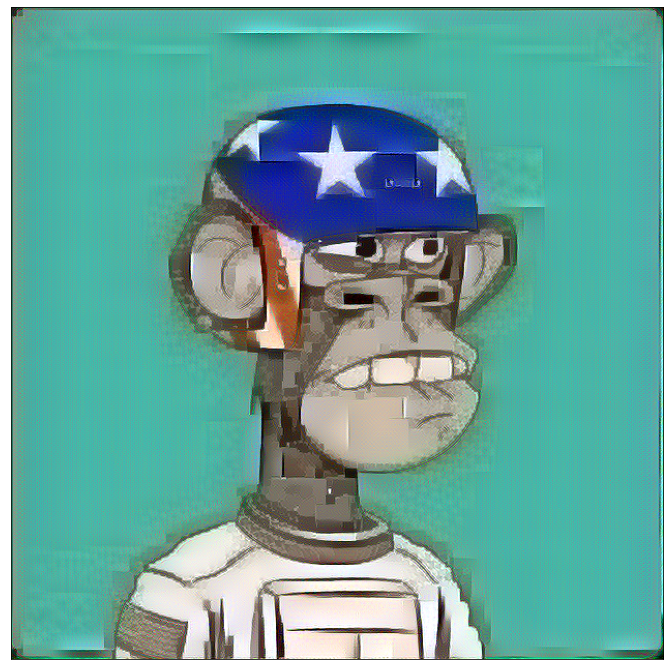

In [58]:
plt.figure(figsize=(12, 12))

# plot best result
display_image(final_img)